In [37]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
#from statsmodels.tsa.seasonal import seasonal_decompose
data=pd.read_csv(r"C:\Users\user\Desktop\AIML_Timeseries\week1\testset.csv")
data['datetime']=data['datetime'].apply(lambda x: datetime.strptime(x,"%Y%m%d-%H:%M"))
data=data.set_index('datetime')
if data['Temperature'].isnull().values.any()==True:
    data[data['Temperature'].isnull()]=data['Temperature'].mean()
newdata = data['2001':].resample('M').mean()
#newdata['Temperature'].isnull().values.any()  
#newdata.head()


In [38]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
def acfpacf(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

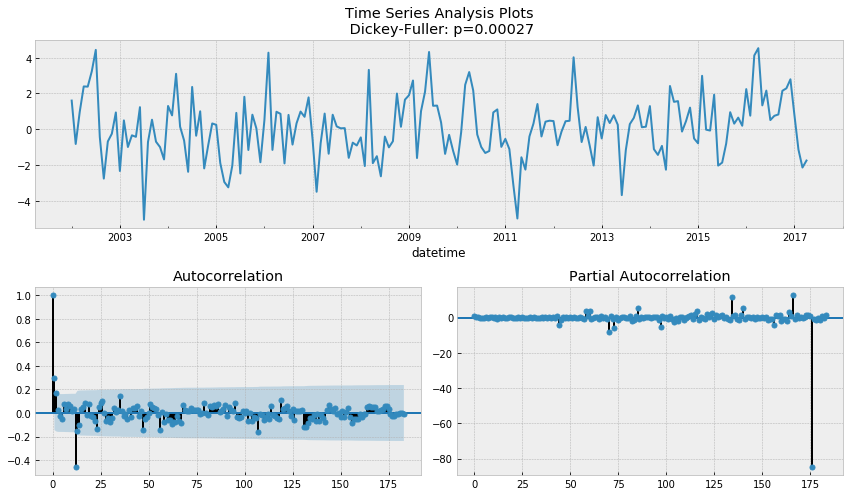

In [40]:
#Checking for stationarity and drawing ACF PACF plots
newdata_diff_m=newdata['Temperature'].diff(12)
newdata_diff_m=newdata_diff_m.dropna()
#res1=pd.concat([newdata['Temperature'],newdata_diff_m],axis=1)
#res1.head(24)
acfpacf(newdata_diff_m)

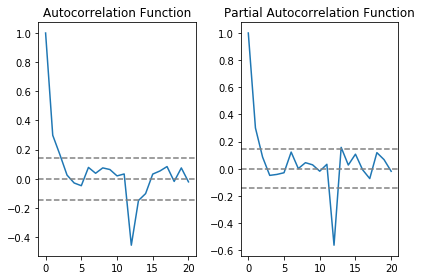

In [31]:
from statsmodels.tsa.stattools import acf, pacf
import numpy as np
lag_acf = acf(newdata_diff_m, nlags=20)
lag_pacf = pacf(newdata_diff_m, nlags=20, method='ols')

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(newdata_diff_m)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(newdata_diff_m)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(newdata_diff_m)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(newdata_diff_m)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()

Plotting ARIMA model
                             ARIMA Model Results                              
Dep. Variable:          D.Temperature   No. Observations:                  195
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -424.087
Method:                       css-mle   S.D. of innovations              2.091
Date:                Fri, 14 Aug 2020   AIC                            860.174
Time:                        16:13:50   BIC                            879.812
Sample:                    02-28-2001   HQIC                           868.126
                         - 04-30-2017                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0148      0.027      0.550      0.583      -0.038       0.067
ar.L1.D.Temperature     1.6971      0.017     97.878      0.000       1.663       1

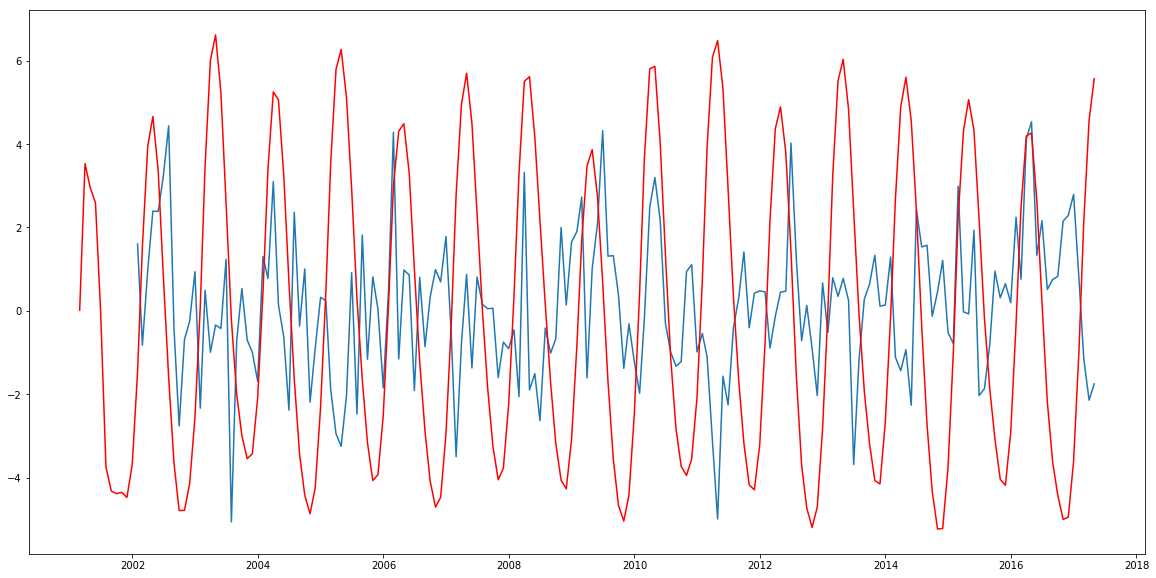

In [46]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(newdata['Temperature'], order=(2,1,2))
results_ARIMA = model.fit(disp=-1)
plt.figure(figsize=(20,10))
plt.plot(newdata_diff_m)
plt.plot(results_ARIMA.fittedvalues, color='red')
print('Plotting ARIMA model')
print(results_ARIMA.summary())

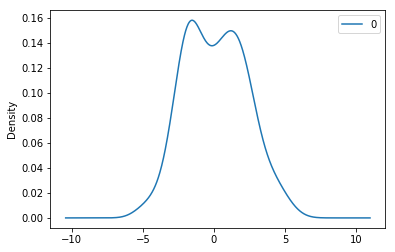

In [47]:
from pandas import DataFrame
residuals = DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde')
plt.show()

In [48]:
print(residuals.describe())

                0
count  195.000000
mean     0.096383
std      2.161372
min     -5.071933
25%     -1.651383
50%      0.125972
75%      1.682701
max      5.614220


In [49]:
pred = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(pred.head())

datetime
2001-02-28    0.014763
2001-03-31    3.530114
2001-04-30    2.957741
2001-05-31    2.592313
2001-06-30   -0.034060
Freq: M, dtype: float64


In [62]:
pred_sum = pred.cumsum()
#print(pred_sum)

In [68]:
pred_new = pd.Series(newdata['Temperature'].iloc[0], index=newdata.index)
pred_new = pred_new.add(pred_sum, fill_value=0)
pred_new.head()

datetime
2001-01-31    12.657776
2001-02-28    12.672539
2001-03-31    16.202652
2001-04-30    19.160394
2001-05-31    21.752707
Freq: M, dtype: float64

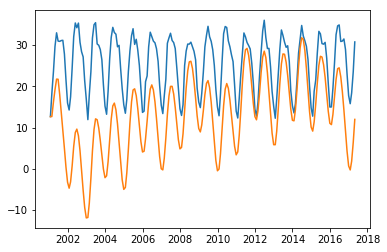

In [71]:
plt.plot(newdata['Temperature'])
plt.plot(pred_new)